In [2]:
import json
import numpy as np
import pandas as pd
import os
import math
import pickle
import tqdm

In [3]:
def load_scores_(mat_path, n_queries):
    mat = np.fromfile(mat_path, dtype=np.float32)[4:]
    n_targets = len(mat) // n_queries
    return mat.reshape(n_queries, n_targets)    

In [4]:
def load_files_(expected_rows, mat_path, features_path):
    features = json.load(open(features_path))
    mat = load_scores_(mat_path, expected_rows)
    np.fill_diagonal(mat, mat.min() - 1) # self dist is not interesting!
    prob_ids = np.array(features['id'])
    return mat, prob_ids

In [5]:
def load_scores(mat_path, matches_path):
    n_queries = len(json.load(open(matches_path)))
    mat = np.fromfile(mat_path, dtype=np.float32)[4:]
    n_targets = len(mat) // n_queries
    return mat.reshape(n_queries, n_targets)    

In [6]:
def load_files(match_path, distractor_mat_path, prob_mat_path, prob_features_path, dist_features_path):
    prob_features = json.load(open(features_path))
    dist_features = json.load(open(dist_features_path))
    distractor_mat = load_scores(distractor_mat_path, match_path)
    prob_mat = load_scores(prob_mat_path, match_path)
    np.fill_diagonal(prob_mat, prob_mat.min() - 1) # self dist is not interesting!
    prob_ids = np.array(prob_features['id'] + dist_features['id'])
    return prob_mat, distractor_mat, prob_ids

In [7]:
def dist_fuse(mat_1, mat_2):
    return (mat_1 + mat_2) / 2

In [8]:
def top1(prob_mat, distractor_mat, prob_ids):
    """ 
        is the target id in the top 1 (not including self image)
        (prob_mat assuming diag is nan)
        prob_ids are a ground truth of ids ordered probmat and distmat entries
    """
    
    #out_max = np.max(distractor_mat, axis=1) # best out of distractor set
    #out_max_labels = np.argmax(distractor_mat, axis=1) # best out of distractor set
    
    np.fill_diagonal(prob_mat, prob_mat.min() - 1)
    tot_mat = np.concatenate((prob_mat, distractor_mat), axis=1) # working with a small matrix :)
    
    top_scores = np.max(tot_mat, axis=1)
    top_labels = np.argmax(tot_mat, axis=1) # indices
    top_labels = prob_ids[top_labels]
    
    return top_labels, top_scores

In [9]:
def topk(prob_mat, distractor_mat, prob_ids, k):
    """ 
        is the target id in the top 1 (not including self image)
        (prob_mat assuming diag is nan)
        prob_ids are a ground truth of ids ordered probmat entries
    """
    
    tot_mat = np.concatenate((prob_mat, distractor_mat), axis=1) # working with a small matrix :)
    out_max_k = -np.partition(-tot_mat, k, axis=1)[:, :k] # best out of distractor set
    out_max_labels_k = np.argpartition(-tot_mat, k, axis=1)[:, :k] # best out of distractor set
    out_max_labels_k = prob_ids[out_max_labels_k]
    
    return out_max_labels_k, out_max_k

In [10]:
def rank1_(prob_mat, distractor_mat, prob_ids):
    """ 
        is the target id in the top 1 (not including self image)
        (prob_mat assuming diag is nan)
        prob_ids are a ground truth of ids ordered probmat entries
    """
    
    out_max = np.max(distractor_mat, axis=1) # best out of distractor set
    tot_mat = np.concatenate((prob_mat, out_max.reshape((prob_mat.shape[0], 1))), axis=1) # working with a small matrix :)
    n_probs = prob_mat.shape[1]
    inf_ = tot_mat.min() - 1
    score = 0
    n_query = 0 
    for query_id in set(prob_ids[:prob_mat.shape[0]]):
        # probes from iden
        row_mask = list((query_id == prob_ids[:prob_mat.shape[0]]))
        curr_id_mat = tot_mat[row_mask, :]
        
        n_id_probs, n_probs_and_one_other = curr_id_mat.shape
        query_indices = np.argwhere(row_mask).T[0]
        for row_i, col_i in enumerate(query_indices):
            # nullify all other cols from indices
            col_mask = row_mask.copy()
            col_mask[col_i] = False
            col_mask.append(False)

            other_probs_sub = curr_id_mat[: , col_mask].copy()
            curr_id_mat[: , col_mask] = inf_

            # calc hits
            top_hits = np.delete(np.argmax(curr_id_mat, axis=1), row_i ,0)
            top_id = prob_ids[top_hits]
            score += sum(top_id == query_id)
            n_query += len(top_id)

            # get them back
            curr_id_mat[:, col_mask] = other_probs_sub
            
    return score/n_query

In [11]:
def open_set_label_and_score(prob_mat, distractor_mat, prob_ids):
    """
         What is the 2nd iden for the prob if he is not in set?
         What is it's score?
    """
    
    indexes = np.unique(prob_ids[:prob_mat.shape[0]], return_index=True)[1]  # ids sorted by apperance
    id_set = [prob_ids[:prob_mat.shape[0]][index] for index in sorted(indexes)]
    res_label = []
    res_score = []
    inf_ = min(distractor_mat.min(), prob_mat.min()) - 1
    for curr_id in id_set:
        # nullify all query cols from indices
        row_mask = list((curr_id == prob_ids[:prob_mat.shape[0]]))
        curr_prob_mat = prob_mat[row_mask, :].copy()
        curr_prob_mat[: , row_mask] = inf_
        
        label, scores = top1(curr_prob_mat, distractor_mat[row_mask, :], prob_ids)
        res_label.extend(label)
        res_score.extend(scores)
    return np.array(res_label), np.array(res_score)

In [12]:
def open_set_label_and_score_topk(prob_mat, distractor_mat, prob_ids):
    """
         What is the 2nd iden for the prob if he is not in set?
         What is it's score?
    """
    
    indexes = np.unique(prob_ids[:prob_mat.shape[0]], return_index=True)[1]  # ids sorted by apperance
    id_set = [prob_ids[:prob_mat.shape[0]][index] for index in sorted(indexes)]
    res_label = []
    res_score = []
    inf_ = min(distractor_mat.min(), prob_mat.min()) - 1
    for curr_id in id_set:
        # nullify all query cols from indices
        row_mask = list((curr_id == prob_ids[:prob_mat.shape[0]]))
        curr_prob_mat = prob_mat[row_mask, :].copy()
        curr_prob_mat[: , row_mask] = inf_
        
        label, scores = topk(curr_prob_mat, distractor_mat[row_mask, :], prob_ids, 3)
        res_label.append(label)
        res_score.append(scores)
    return np.vstack(res_label), np.vstack(res_score)

In [13]:
def model_agreement(prob_mat_0, distractor_mat_0, prob_mat_1, distractor_mat_1, prob_ids):
    open_set_k_labels_0, open_set_k_scores_0  = open_set_label_and_score_topk(prob_mat_0, distractor_mat_0, prob_ids)
    open_set_k_labels_1, open_set_k_scores_1 = open_set_label_and_score_topk(prob_mat_1, distractor_mat_1, prob_ids)

    a = 0
    for row_0, row_1 in zip(open_set_k_labels_0, open_set_k_labels_1):
        a+= (len(np.intersect1d(row_0, row_1)) > 0)
    b = len(prob_ids)
    print('\n any(2nd,3rd,4th) iden Corr=%0.1f%% \n' % (100.0*a / b) )

In [14]:
def agreement_models(prob_mat_0, distractor_mat_0, prob_mat_1, distractor_mat_1, prob_ids):
    print('Agreement model')
    top1_labels_0, top1_scores_0 = top1(prob_mat_0, distractor_mat_0, prob_ids)
    top1_labels_1, top1_scores_1 = top1(prob_mat_1, distractor_mat_1, prob_ids)

    open_set_1st_labels_0, open_set_1st_scores_0  = open_set_label_and_score(prob_mat_0, distractor_mat_0, prob_ids)
    open_set_1st_labels_1, open_set_1st_scores_1 = open_set_label_and_score(prob_mat_1, distractor_mat_1, prob_ids)
    
    a = np.sum((open_set_1st_labels_0 == open_set_1st_labels_1))
    b = prob_mat_0.shape[0]
    corr = (100.0*a / b)
    print('2nd iden Corr=%0.1f%%' % corr )

    target_FTRS = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
    thresholds = np.unique(np.concatenate((top1_scores_0,top1_scores_1,
                                              open_set_1st_scores_0,open_set_1st_scores_1)))

    models_agree = (open_set_1st_labels_0 == open_set_1st_labels_1)
    FTRs = [np.sum(models_agree & (open_set_1st_scores_0 > TH) & (open_set_1st_scores_1 > TH)) / b
            for TH in thresholds]
    
    mod_0_corr = (top1_labels_0 == prob_ids[:prob_mat_0.shape[0]])
    mod_1_corr = (top1_labels_1 == prob_ids[:prob_mat_0.shape[0]])
    TTRs = [np.sum( (top1_scores_0 > TH) &
                    (top1_scores_1 > TH) &
                     mod_0_corr &
                     mod_1_corr ) / b for TH, FTR in zip(thresholds, FTRs)]

    target_TTRs = []
    for target_FTR in target_FTRS:
        if (FTRs[0] <= target_FTR):
            print('FTR=%0.1f%%, TTR=%0.1f%%' % (target_FTR * 100, TTRs[0] * 100))
            target_TTRs.append(TTRs[0])
            continue
        for TH, FTR, TTR in zip(thresholds, FTRs, TTRs):
            if math.isclose(FTR, target_FTR, abs_tol = 0.001):
                print('FTR=%0.1f%%, TTR=%0.1f%%' % (FTR * 100, TTR * 100))
                target_TTRs.append(TTR)
                break
        
    return np.array(thresholds), np.array(FTRs), np.array(TTRs), np.array(target_TTRs), corr

In [15]:
def dist_fuse_models(prob_mat_0, distractor_mat_0, prob_mat_1, distractor_mat_1, prob_ids):
    print('\nDist_fuse model')
    #rank1_0 = rank1_(prob_mat_0, distractor_mat_0, prob_ids)
    #rank1_1 = rank1_(prob_mat_1, distractor_mat_1, prob_ids)
    prob_mat = dist_fuse(prob_mat_0,prob_mat_1)
    distractor_mat = dist_fuse(distractor_mat_0, distractor_mat_1)
    rank1_fuse = rank1_(prob_mat, distractor_mat, prob_ids)
    print(rank1_fuse)
    """
    print('Rank-1:\n model0:{} \n model1:{} \n mean_fuse:{}'.format(rank1_0, rank1_1, rank1_fuse))
    
    top1_labels, top1_scores = top1(prob_mat, distractor_mat, prob_ids)
    open_set_1st_labels, open_set_1st_scores = open_set_label_and_score(prob_mat, distractor_mat, prob_ids)

    target_FTRS = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
    thresholds = np.unique(np.concatenate((top1_scores, open_set_1st_scores)))

    FTRs = [np.sum((open_set_1st_scores > TH)) / prob_mat.shape[0] for TH in thresholds]
    mod_corr = (top1_labels == prob_ids[:prob_mat_0.shape[0]])
    TTRs = [np.sum( (top1_scores > TH) &
                     mod_corr) / prob_mat.shape[0] for TH, FTR in zip(thresholds, FTRs)]

    target_TTRs = []
    for target_FTR in target_FTRS:
        if (FTRs[0] <= target_FTR):
            print('FTR=%0.1f%%, TTR=%0.1f%%' % (target_FTR * 100, TTRs[0] * 100))
            target_TTRs.append(TTRs[0])
            continue
        for TH, FTR, TTR in zip(thresholds, FTRs, TTRs):
            if math.isclose(FTR, target_FTR, abs_tol = 0.001):
                print('FTR=%0.1f%%, TTR=%0.1f%%' % (FTR * 100, TTR * 100))
                target_TTRs.append(TTR)
                break
    """
    return rank1_fuse

In [16]:
def get_verification(cmc_path, idx):
    cmc = json.load(open(cmc_path))
    for TH, acc in zip(*cmc['roc']):
        if math.isclose(TH, 1e-6, abs_tol = 1e-6) and TH > 1e-6:
            print('Verification %d: %0.4f%%' % (idx, acc))
            break

In [17]:
def get_results(name_dir, id_sample=.5, img_sample=0, times=10):
    # load data
    mat_path = "results_vgg/"+name_dir+"/"+name_dir+"_0/otherFiles/vgg2_vgg2_"+name_dir+"_0.bin"
    features_path = "results_vgg/"+name_dir+"/"+name_dir+"_0/otherFiles/vgg2_features_"+name_dir+"_0"
    mat_0, prob_ids_tot = load_files_(expected_rows, mat_path, features_path)

    if 'morph' in name_dir:
        mat_path = "results_vgg/morph0.01/morph0.01_2020/otherFiles/vgg2_vgg2_morph0.01_2020.bin"
        features_path = "results_vgg/morph0.01/morph0.01_2020/otherFiles/vgg2_features_morph0.01_2020"
        mat_1, _ = load_files_(expected_rows, mat_path, features_path)
    else:
        mat_path = "results_vgg/"+name_dir+"/"+name_dir+"_1/otherFiles/vgg2_vgg2_"+name_dir+"_1.bin"
        features_path = "results_vgg/"+name_dir+"/"+name_dir+"_1/otherFiles/vgg2_features_"+name_dir+"_1"
        mat_1, _ = load_files_(expected_rows, mat_path, features_path)

    for i in tqdm.tqdm_notebook(range(times), total=times):
        # filter probes to rows with more then one iden
        ids, counts = np.unique(prob_ids_tot, return_counts=True)
        np.random.shuffle(ids)
        selected_id = ids[:np.int(np.floor(id_sample*len(ids)))]
        prob_ids_mask = np.isin(prob_ids_tot, selected_id)
        prob_ids_ = prob_ids_tot[prob_ids_mask]
        dist_ids_ = prob_ids_tot[~prob_ids_mask]
        prob_ids = np.concatenate((prob_ids_, dist_ids_))
        prob_mat_0 = mat_0[prob_ids_mask][:, prob_ids_mask]
        distractor_mat_0 = mat_0[prob_ids_mask][:, ~prob_ids_mask]
        prob_mat_1 = mat_1[prob_ids_mask][:, prob_ids_mask]
        distractor_mat_1 = mat_1[prob_ids_mask][:, ~prob_ids_mask]

        if img_sample>0:
            # for each iden - sample at most 4 images
            get_samples = lambda x: x.values.T[0] if len(x) < img_sample else x.sample(n=img_sample, replace=False).values.T[0]
            name_over_ind = pd.DataFrame(prob_ids_).reset_index().set_index(0).rename(columns={'index':'ind'}).groupby(0)
            sampled_indices = np.hstack(name_over_ind.apply(lambda x: get_samples(x)).values.tolist())
            sampled_ids = name_over_ind.apply(lambda x: get_samples(x)).index.tolist()
            prob_mat_0 = prob_mat_0[sampled_indices][:, sampled_indices]
            distractor_mat_0 = distractor_mat_0[sampled_indices]
            prob_mat_1 = prob_mat_1[sampled_indices][:, sampled_indices]
            distractor_mat_1 = distractor_mat_1[sampled_indices]
            prob_ids = np.concatenate((prob_ids_[sampled_indices], dist_ids_))

        # send to calc
        res = dict()
        thresholds, FTRs, TTR, target_TTRs, corr = agreement_models(prob_mat_0, distractor_mat_0, prob_mat_1, distractor_mat_1, prob_ids)
        rank1_fuse = dist_fuse_models(prob_mat_0, distractor_mat_0, prob_mat_1, distractor_mat_1, prob_ids)
        res['corr'] = corr
        res['thresholds'] = thresholds
        res['FTRs'] = FTRs
        res['TTR'] = TTR
        res['target_TTRs'] = target_TTRs
        #res['fuse_thresholds'] = fuse_thresholds
        #res['fuse_FTRs'] = fuse_FTRs
        #res['fuse_TTR'] = fuse_TTR
        res['rank1_fuse'] = rank1_fuse
        #res['fuse_target_TTRs'] = fuse_target_TTRs
        #return res
        pickle.dump(res, open('results_vgg/sample.2_mean_'+str(i)+'_'+name_dir+'.pkl', 'wb'))

In [18]:
expected_rows = 46733
res_collection = dict()

In [18]:
score_dirs = ['baseline', 
              'pearson_.9', 'pearson_.75', 'pearson_.5', 'pearson_.25', 'pearson_.1',
              'mean_.9', 'mean_.75', 'mean_.5', 'mean_.25', 'mean_.1',
              'ncl', 'morph0.1', 'morph0.05', 'morph0.01']

In [68]:
# for name_dir in tqdm.tqdm_notebook(score_dirs, total=len(score_dirs), desc=str(i)):
name_dir = 'morph0.05'
#for i in tqdm.tqdm_notebook(range(10), total=10):
get_results(name_dir, id_sample=.2, img_sample=10)
    #res_collection[name_dir] = 
    #pickle.dump(res_collection[name_dir], open('results_vgg/sample.2_mean_'+str(i)+'_'+name_dir+'.pkl', 'wb'))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


Agreement model
2nd iden Corr=35.9%
FTR=0.1%, TTR=0.4%
FTR=0.2%, TTR=18.2%
FTR=1.1%, TTR=47.9%
FTR=10.0%, TTR=93.5%
FTR=20.0%, TTR=93.8%
FTR=30.0%, TTR=93.8%

Dist_fuse model
0.8204444444444444
Agreement model
2nd iden Corr=30.0%
FTR=0.1%, TTR=14.8%
FTR=0.2%, TTR=16.9%
FTR=1.1%, TTR=75.3%
FTR=10.0%, TTR=92.3%
FTR=20.0%, TTR=93.0%
FTR=30.0%, TTR=93.2%

Dist_fuse model
0.8001111111111111
Agreement model
2nd iden Corr=36.9%
FTR=0.1%, TTR=2.2%
FTR=0.2%, TTR=6.5%
FTR=1.1%, TTR=32.9%
FTR=10.0%, TTR=91.4%
FTR=20.0%, TTR=91.9%
FTR=30.0%, TTR=92.0%

Dist_fuse model
0.7474444444444445
Agreement model
2nd iden Corr=35.5%
FTR=0.1%, TTR=9.4%
FTR=0.2%, TTR=29.6%
FTR=1.1%, TTR=87.9%
FTR=10.0%, TTR=91.4%
FTR=20.0%, TTR=91.7%
FTR=30.0%, TTR=92.0%

Dist_fuse model
0.7942222222222223
Agreement model
2nd iden Corr=35.8%
FTR=0.1%, TTR=86.3%
FTR=0.2%, TTR=89.0%
FTR=1.1%, TTR=91.9%
FTR=10.0%, TTR=93.6%
FTR=20.0%, TTR=94.1%
FTR=30.0%, TTR=94.1%

Dist_fuse model
0.826
Agreement model
2nd iden Corr=34.0%
FTR=0.

In [25]:
score_dirs = [
              'pearson_.9', 'pearson_.75', 
              'mean_.9', 'mean_.75', 'mean_.5', 'mean_.25', 'mean_.1',
              'ncl', 'morph0.1', 'morph0.05', 'morph0.01']

In [26]:
# load res
for name_dir in score_dirs:
    print(name_dir)
    res_collection[name_dir]= dict()
    for i in range(10):
        res_collection[name_dir][i] = pickle.load(open('results_vgg/sample.2_mean_'+str(i)+'_'+name_dir+'.pkl', 'rb'))

pearson_.9
pearson_.75
mean_.9
mean_.75
mean_.5
mean_.25
mean_.1
ncl
morph0.1
morph0.05
morph0.01


In [31]:
# get res
for attr in ['target_TTRs']:
    res_collection[attr] = pd.DataFrame(np.vstack(
        [np.mean([res_collection[name_dir][i][attr][-5:] for i in range(10)], axis=0)] for name_dir in score_dirs),
                                       index=score_dirs)
for attr in ['rank1_fuse', 'corr']:
    res_collection[attr] = pd.DataFrame(np.vstack(
        [np.mean([res_collection[name_dir][i][attr] for i in range(10)], axis=0)] for name_dir in score_dirs),
                                       index=score_dirs)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  after removing the cwd from sys.path.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


In [32]:
def getTTRs(target_FTR = 0.001):
    target_TTRs = []
    for key in score_dirs:
        target_TTRs = []
        for ind in range(10):
            FTRs = res_collection[key][ind]['FTRs']
            TTRs = res_collection[key][ind]['TTR']
            if (FTRs[0] <= target_FTR):
                #print('FTR=%0.5f%%, TTR=%0.1f%%' % (target_FTR, TTRs[0] * 100))
                target_TTRs.append(TTRs[0])
                continue
            for FTR, TTR in zip(FTRs, TTRs):
                if math.isclose(FTR, target_FTR, abs_tol = 0.001):
                    #print('FTR=%0.5f%%, TTR=%0.1f%%' % (FTR, TTR * 100))
                    target_TTRs.append(TTR)
                    break
        res_collection[key][target_FTR] = np.mean(target_TTRs)

In [33]:
for TH in np.arange(1e-3, 1e-2, 1e-3):
    getTTRs(TH)
    res_collection['target_TTRs'][TH] = [res_collection[key][TH] for key in score_dirs]

In [45]:
#res_collection['target_TTRs'].columns = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3] + res_collection['target_TTRs'].columns[6:].tolist()
res_collection['target_TTRs'].sort_values(0.005)

,0.0001,0.001,0.01,0.1,0.2,0.3,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009000000000000001
mean_.25,0.1648,0.6016,0.9231,0.9274,0.9286,0.1648,0.1923,0.2388,0.2895,0.3305,0.3661,0.4362,0.5032,0.5476
morph0.1,0.2458,0.7380,0.9189,0.9241,0.9248,0.2458,0.2914,0.3512,0.3931,0.4300,0.4714,0.5297,0.6635,0.6997
morph0.01,0.3333,0.6024,0.9208,0.9255,0.9270,0.3333,0.3558,0.3934,0.4197,0.4443,0.4614,0.4829,0.5531,0.5805
ncl,0.2726,0.7030,0.9283,0.9341,0.9352,0.2726,0.3033,0.3595,0.4257,0.4520,0.4976,0.5275,0.6182,0.6716
pearson_.75,0.3148,0.6546,0.9162,0.9194,0.9200,0.3148,0.3442,0.3853,0.4057,0.4530,0.4826,0.5227,0.5645,0.6358
mean_.9,0.2799,0.7456,0.9218,0.9231,0.9231,0.2799,0.3226,0.3993,0.4435,0.4721,0.5145,0.5692,0.6185,0.6804
mean_.1,0.3488,0.7215,0.9246,0.9296,0.9313,0.3488,0.3739,0.4000,0.4528,0.4791,0.5041,0.5523,0.6154,0.6820
mean_.5,0.4095,0.6434,0.9166,0.9175,0.9175,0.4095,0.4362,0.4690,0.4888,0.5090,0.5297,0.5685,0.5913,0.6246
morph0.05,0.3878,0.7534,0.9229,0.9290,0.9307,0.3899,0.4208,0.4445,0.4757,0.5411,0.5919,0.6543,0.6961,0.7293
pearson_.9,0.3912,0.7122,0.9016,0.9052,0.9052,0.3912,0.4307,0.4712,0.5033,0.5444,0.5736,0.6336,0.6791,0.7058


In [105]:
target_FTRS = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
res_collection['target_TTRs'].columns = target_FTRS

In [29]:
res_collection['target_TTRs'].

,0,1,2,3,4,5
pearson_.9,0.3476,0.3912,0.7122,0.9016,0.9052,0.9052
pearson_.75,0.2959,0.3148,0.6546,0.9162,0.9194,0.9200
mean_.9,0.2204,0.2799,0.7456,0.9218,0.9231,0.9231
mean_.75,0.4044,0.4644,0.7675,0.9327,0.9359,0.9372
mean_.5,0.3593,0.4095,0.6434,0.9166,0.9175,0.9175
mean_.25,0.1400,0.1648,0.6016,0.9231,0.9274,0.9286
mean_.1,0.2963,0.3488,0.7215,0.9246,0.9296,0.9313
ncl,0.2288,0.2726,0.7030,0.9283,0.9341,0.9352


In [268]:
target_FTR = 0.001
target_TTRs = []

for ind in res_table.index:
    FTRs = res_table['FTRs'][ind]
    TTRs = res_table['TTR'][ind]
    if (FTRs[0] <= target_FTR):
        print('FTR=%0.1f%%, TTR=%0.1f%%' % (target_FTR * 100, TTRs[0] * 100))
        target_TTRs.append(TTRs[0])
        continue
    for FTR, TTR in zip(FTRs, TTRs):
        if math.isclose(FTR, target_FTR, abs_tol = 0.001):
            print('FTR=%0.1f%%, TTR=%0.1f%%' % (FTR * 100, TTR * 100))
            target_TTRs.append(TTR)
            break

FTR=0.2%, TTR=38.6%
FTR=0.2%, TTR=39.4%
FTR=0.2%, TTR=44.6%
FTR=0.2%, TTR=33.2%
FTR=0.2%, TTR=38.6%
FTR=0.2%, TTR=44.0%
FTR=0.2%, TTR=40.2%
FTR=0.2%, TTR=40.2%
FTR=0.2%, TTR=37.4%
FTR=0.2%, TTR=34.3%
FTR=0.2%, TTR=46.8%
FTR=0.2%, TTR=40.5%
FTR=0.2%, TTR=36.6%
FTR=0.2%, TTR=31.6%
FTR=0.2%, TTR=34.9%


In [269]:
target_TTRs

[0.3856465250567127,
 0.39368942049907196,
 0.4464838110950711,
 0.33223345019591666,
 0.38585275314497836,
 0.43967828418230565,
 0.40214477211796246,
 0.4015260878531656,
 0.37368529593730665,
 0.34336976696226024,
 0.46751907609816457,
 0.4050319653536812,
 0.36584862858321304,
 0.31594143122293256,
 0.34914415343369765]

In [70]:
target_FTRS = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
FTRS_table =pd.DataFrame(res_table['target_TTRs'].values.tolist(), index=res_table['target_TTRs'].index, columns=target_FTRS)

NameError: name 'res_table' is not defined

In [271]:
FTRS_table['rank1_fuse'] = res_table['rank1_fuse']

In [282]:
pd.options.display.float_format = '{:.3f}'.format
print((FTRS_table[['rank1_fuse', 0.01, 0.1, 0.1]]*100).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  rank1\_fuse &   0.01 &    0.1 &    0.1 \\
\midrule
baseline    &      98.827 & 38.565 & 99.072 & 99.072 \\
mean\_.1     &      98.959 & 39.369 & 99.031 & 99.031 \\
mean\_.25    &      98.903 & 44.648 & 99.010 & 99.010 \\
mean\_.5     &      98.921 & 33.223 & 98.928 & 98.928 \\
mean\_.75    &      98.978 & 38.585 & 99.072 & 99.072 \\
mean\_.9     &      99.007 & 43.968 & 98.969 & 98.969 \\
morph0.01   &      98.978 & 40.214 & 99.010 & 99.010 \\
morph0.05   &      98.827 & 40.153 & 99.031 & 99.031 \\
morph0.1    &      98.874 & 37.369 & 98.989 & 98.989 \\
ncl         &      98.855 & 34.337 & 99.031 & 99.031 \\
pearson\_.1  &      99.007 & 46.752 & 99.093 & 99.093 \\
pearson\_.25 &      99.082 & 40.503 & 99.010 & 99.010 \\
pearson\_.5  &      98.836 & 36.585 & 98.989 & 98.989 \\
pearson\_.75 &      98.903 & 31.594 & 99.010 & 99.010 \\
pearson\_.9  &      98.562 & 34.914 & 98.701 & 98.701 \\
\bottomrule
\end{tabular}



In [235]:
pd.options.display.float_format = '{:.2f}'.format
print(FTRS_table.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  0.0001 &  0.01 &  0.1 &  0.2 &  0.3 &  rank1\_fuse \\
\midrule
baseline    &    0.33 &  0.97 & 0.99 & 0.99 & 0.99 &        0.99 \\
mean\_.1     &    0.31 &  0.98 & 0.99 & 0.99 & 0.99 &        0.99 \\
mean\_.25    &    0.38 &  0.97 & 0.99 & 0.99 & 0.99 &        0.99 \\
mean\_.5     &    0.28 &  0.97 & 0.99 & 0.99 & 0.99 &        0.99 \\
mean\_.75    &    0.33 &  0.97 & 0.99 & 0.99 & 0.99 &        0.99 \\
mean\_.9     &    0.34 &  0.97 & 0.99 & 0.99 & 0.99 &        0.99 \\
morph0.01   &    0.26 &  0.98 & 0.99 & 0.99 & 0.99 &        0.99 \\
morph0.05   &    0.33 &  0.97 & 0.99 & 0.99 & 0.99 &        0.99 \\
morph0.1    &    0.26 &  0.98 & 0.99 & 0.99 & 0.99 &        0.99 \\
ncl         &    0.22 &  0.98 & 0.99 & 0.99 & 0.99 &        0.99 \\
pearson\_.1  &    0.36 &  0.98 & 0.99 & 0.99 & 0.99 &        0.99 \\
pearson\_.25 &    0.34 &  0.98 & 0.99 & 0.99 & 0.99 &        0.99 \\
pearson\_.5  &    0.32 &  0.97 & 0.99 & 0.99 & 0.99 &        0.99 \\
pears

In [180]:
target_FTRS = [0.0001, 0.01, 0.1, 0.2, 0.3]
.sort_values(by=0.0001)

,0.0001,0.01,0.1,0.2,0.3
ncl,0.223964,0.978346,0.990307,0.991751,0.991751
morph0.1,0.257785,0.977109,0.989895,0.990514,0.990514
morph0.01,0.259229,0.978759,0.990101,0.990926,0.991132
mean_.5,0.275727,0.968447,0.989276,0.989276,0.989276
pearson_.9,0.288513,0.956073,0.987008,0.987008,0.987008
pearson_.75,0.292638,0.977934,0.990101,0.990307,0.990307
mean_.1,0.314910,0.980202,0.990307,0.990720,0.990926
pearson_.5,0.324191,0.971128,0.989895,0.990514,0.990720
morph0.05,0.327903,0.970097,0.990307,0.991132,0.991132
mean_.75,0.329140,0.969684,0.990720,0.991338,0.991545


In [182]:
pd.DataFrame(res_table['target_TTRs'].values.tolist(), index=res_table['target_TTRs'].index, columns=target_FTRS).sort_values(by=0.01)

,0.0001,0.01,0.1,0.2,0.3
pearson_.9,0.288513,0.956073,0.987008,0.987008,0.987008
mean_.5,0.275727,0.968447,0.989276,0.989276,0.989276
mean_.75,0.329140,0.969684,0.990720,0.991338,0.991545
baseline,0.330584,0.970097,0.990720,0.991132,0.991751
morph0.05,0.327903,0.970097,0.990307,0.991132,0.991132
pearson_.5,0.324191,0.971128,0.989895,0.990514,0.990720
mean_.25,0.380285,0.972778,0.990101,0.990720,0.990926
mean_.9,0.339039,0.974840,0.989689,0.989895,0.989895
morph0.1,0.257785,0.977109,0.989895,0.990514,0.990514
pearson_.75,0.292638,0.977934,0.990101,0.990307,0.990307


In [183]:
pd.DataFrame(res_table['target_TTRs'].values.tolist(), index=res_table['target_TTRs'].index, columns=target_FTRS).sort_values(by=0.1)

,0.0001,0.01,0.1,0.2,0.3
pearson_.9,0.288513,0.956073,0.987008,0.987008,0.987008
mean_.5,0.275727,0.968447,0.989276,0.989276,0.989276
mean_.9,0.339039,0.974840,0.989689,0.989895,0.989895
morph0.1,0.257785,0.977109,0.989895,0.990514,0.990514
pearson_.5,0.324191,0.971128,0.989895,0.990514,0.990720
mean_.25,0.380285,0.972778,0.990101,0.990720,0.990926
morph0.01,0.259229,0.978759,0.990101,0.990926,0.991132
pearson_.25,0.335946,0.980408,0.990101,0.991132,0.991545
pearson_.75,0.292638,0.977934,0.990101,0.990307,0.990307
mean_.1,0.314910,0.980202,0.990307,0.990720,0.990926


In [281]:
pd.DataFrame(res_table['target_TTRs'].values.tolist(), index=res_table['target_TTRs'].index, columns=target_FTRS).sort_values(by=0.1)

,0.0001,0.01,0.1,0.2,0.3
pearson_.9,0.289,0.956,0.987,0.987,0.987
mean_.5,0.276,0.968,0.989,0.989,0.989
mean_.9,0.339,0.975,0.990,0.990,0.990
pearson_.75,0.293,0.978,0.990,0.990,0.990
morph0.1,0.258,0.977,0.990,0.991,0.991
pearson_.5,0.324,0.971,0.990,0.991,0.991
mean_.1,0.315,0.980,0.990,0.991,0.991
mean_.25,0.380,0.973,0.990,0.991,0.991
morph0.01,0.259,0.979,0.990,0.991,0.991
baseline,0.331,0.970,0.991,0.991,0.992


In [65]:
import matplotlib.pylab as plt
import matplotlib
%matplotlib inline

Text(0.5,1,'Open set DIR - Agreement based')

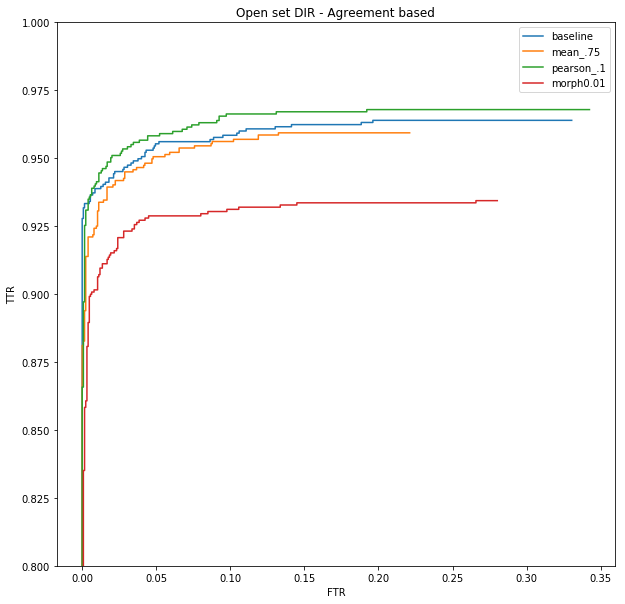

In [117]:
short_list = ['baseline', 'mean_.75', 'pearson_.1', 'morph0.01']
plt.figure(figsize=(10,10))
for name_dir in short_list:
    plt.plot(res_collection[name_dir][0]['FTRs'], res_collection[name_dir][0]['TTR'], label=name_dir)
plt.xlabel('FTR')
plt.ylabel('TTR')
plt.ylim([0.8, 1])
#plt.xscale('log')
#plt.xlim([5e-4, 1e-1])
plt.legend()
plt.title('Open set DIR - Agreement based')

Text(0.5,1,'Open set DIR - Agreement based')

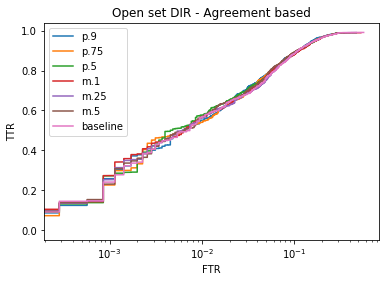

In [158]:
# TODO flip axis?
# TODO add a dash line for cieling?
plt.plot(p9_FTRs, p9_TTR, label='p.9')
plt.plot(p75_FTRs, p75_TTR, label='p.75')
plt.plot(p5_FTRs, p5_TTR, label='p.5')

plt.plot(m1_FTRs, m1_TTR, label='m.1')
plt.plot(m25_FTRs, m25_TTR, label='m.25')
plt.plot(m5_FTRs, m5_TTR, label='m.5')

plt.plot(baseline_FTRs, baseline_TTR, label='baseline')
plt.xlabel('FTR')
plt.ylabel('TTR')
#plt.ylim([0, .4])
plt.xscale('log')
#plt.xlim([1e-4, 1e-2])
plt.legend()
plt.title('Open set DIR - Agreement based')